## Summary
The study Balanced Risk Set Matching applies a novel matching technique to improve causal inference in observational studies. Using integer programming and risk set matching, the method ensures covariate balance while preserving the temporal structure of treatment assignment. It is used to evaluate the effects of cystoscopy and hydrodistention on interstitial cystitis, a chronic bladder condition.


## Contributors
- Pantino, Prince Isaac
- Singh, Fitzsixto Angelo

## **Objective**

This study aims to apply **Balanced Risk Set Matching** as a statistical method to improve causal inference in observational studies where treatment assignment is based on evolving patient conditions rather than randomization. By implementing **risk set matching**, treated patients are paired with untreated patients who had similar symptom histories up to the time of treatment, ensuring comparability at the moment of intervention. Additionally, **integer programming** is used to balance the distributions of key covariates across matched groups, minimizing bias in treatment effect estimation. 

This approach is applied to analyze the impact of **cystoscopy and hydrodistention on interstitial cystitis symptoms**, with a **sensitivity analysis** assessing the robustness of findings to hidden biases. The study ultimately aims to enhance the validity of treatment comparisons in non-randomized medical research.

---

## **Workflow**

### **Step 1: Data Collection & Preprocessing**
- Load or simulate the dataset, ensuring it contains treatment times, symptom histories, and follow-up measures.
- Standardize symptom measures for comparability.
- Identify treated vs. untreated patients and structure data for time-sequenced analysis.
- **Output:** Cleaned dataset with time-ordered symptom histories and treatment indicators.


### **Step 2: Risk Set Matching**
- Identify **risk sets** by finding untreated patients who have a **similar symptom history** as a treated patient up to the time of treatment.
- Ensure that **future data is not used** for matching.
- Compute **Mahalanobis distance** to measure similarity between treated and untreated patients.
- **Output:** Initial pool of potential matches.


### **Step 3: Optimal Matching via Integer Programming**
- Implement **integer programming** to:
  - Minimize **Mahalanobis distance** between treated and control pairs.
  - Ensure **balanced covariate distributions** across groups.
- Use **network flow optimization** to efficiently find the best matches.
- **Output:** Finalized matched dataset with treatment-control pairs.


### **Step 4: Sensitivity Analysis for Hidden Bias**
- Introduce an **unobserved covariate** to simulate hidden biases.
- Evaluate how much hidden bias would be needed to **invalidate the results**.
- Conduct **proportional hazards modeling** to analyze potential confounders.
- **Output:** Bias-adjusted estimates of treatment effects.


### **Step 5: Statistical Analysis & Interpretation**
- Perform **hypothesis testing** to compare treatment vs. control groups:
  - **Wilcoxon Signed-Rank Test** for pairwise comparisons.
  - **Permutation tests** to validate significance.
  - **Multivariate analysis** if multiple symptom outcomes are evaluated.
- Generate **visualizations** (boxplots, histograms) to inspect trends in symptom changes.
- **Output:** Statistical validation of treatment effects.


### **Step 6: Reporting & Conclusion**
- Summarize **methodology, findings, and potential biases**.
- Present results through:
  - **Summary tables** (descriptive statistics).
  - **Graphs & charts** (symptom trends over time).
  - **Sensitivity analysis conclusions** (robustness of findings).
- **Output:** Final research paper/report with validated conclusions.

___

## Step 1: Data Collection and Preprocessing

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from IPython.display import display, HTML
import pulp
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns


#  Set seed for reproducibility
np.random.seed(42)

# Number of patients
n = 200

# Generate patient identifiers and entry times
patient_id = np.arange(1, n + 1)
entry_time = np.random.uniform(0, 12, size=n)  # entry times between 0 and 12 months

# Simulate treatment assignment (30% treated)
treated = np.random.binomial(1, 0.3, size=n)

# Simulate treatment_time: if treated, assign a random time between entry_time+1 and entry_time+6; else NA.
treatment_time = []
for et, t in zip(entry_time, treated):
    if t == 1:
        # Ensure treatment time is after entry (et+1 to et+6)
        treatment_time.append(np.random.uniform(et + 1, et + 6))
    else:
        treatment_time.append(np.nan)
treatment_time = np.array(treatment_time)

# Simulate baseline symptom measures (scores on a 0-9 scale)
pain_baseline = np.random.randint(0, 10, size=n)
urgency_baseline = np.random.randint(0, 10, size=n)
frequency_baseline = np.random.randint(0, 10, size=n)

# Helper function to simulate improvement (ensuring scores don't fall below 0)
def simulate_improvement(baseline):
    improvement = np.random.randint(0, 4)  # improvement between 0 and 3 points
    return max(baseline - improvement, 0)

# Simulate symptom measures at treatment time and follow-ups for treated patients.
pain_treatment = []
urgency_treatment = []
frequency_treatment = []
pain_3months = []
urgency_3months = []
frequency_3months = []
pain_6months = []
urgency_6months = []
frequency_6months = []

for i in range(n):
    if treated[i] == 1:
        # At treatment time: simulate some improvement from baseline
        pt = simulate_improvement(pain_baseline[i])
        ut = simulate_improvement(urgency_baseline[i])
        ft = simulate_improvement(frequency_baseline[i])
        pain_treatment.append(pt)
        urgency_treatment.append(ut)
        frequency_treatment.append(ft)
        
        # 3 months after treatment: further slight improvement or stability
        pain_3 = simulate_improvement(pt)
        urgency_3 = simulate_improvement(ut)
        frequency_3 = simulate_improvement(ft)
        pain_3months.append(pain_3)
        urgency_3months.append(urgency_3)
        frequency_3months.append(frequency_3)
        
        # 6 months after treatment: simulate similarly
        pain_6 = simulate_improvement(pain_3)
        urgency_6 = simulate_improvement(urgency_3)
        frequency_6 = simulate_improvement(frequency_3)
        pain_6months.append(pain_6)
        urgency_6months.append(urgency_6)
        frequency_6months.append(frequency_6)
    else:
        # For untreated patients, these treatment-specific measures are not available.
        pain_treatment.append(np.nan)
        urgency_treatment.append(np.nan)
        frequency_treatment.append(np.nan)
        
        pain_3months.append(np.nan)
        urgency_3months.append(np.nan)
        frequency_3months.append(np.nan)
        
        pain_6months.append(np.nan)
        urgency_6months.append(np.nan)
        frequency_6months.append(np.nan)

# Convert lists to arrays
pain_treatment = np.array(pain_treatment)
urgency_treatment = np.array(urgency_treatment)
frequency_treatment = np.array(frequency_treatment)
pain_3months = np.array(pain_3months)
urgency_3months = np.array(urgency_3months)
frequency_3months = np.array(frequency_3months)
pain_6months = np.array(pain_6months)
urgency_6months = np.array(urgency_6months)
frequency_6months = np.array(frequency_6months)

# Simulate demographic variables
age = np.random.randint(20, 81, size=n)  # age between 20 and 80
gender = np.random.binomial(1, 0.5, size=n)  # 0 = female, 1 = male

# Initialize matched_pair_id (to be assigned after matching) as NA
matched_pair_id = [np.nan] * n

# Simulate an unobserved factor (hidden bias variable)
unobserved_factor = np.random.normal(0, 1, size=n)

# Create the DataFrame
data = pd.DataFrame({
    'patient_id': patient_id,
    'entry_time': entry_time,
    'treatment_time': treatment_time,
    'treated': treated,
    'pain_baseline': pain_baseline,
    'urgency_baseline': urgency_baseline,
    'frequency_baseline': frequency_baseline,
    'pain_treatment': pain_treatment,
    'urgency_treatment': urgency_treatment,
    'frequency_treatment': frequency_treatment,
    'pain_3months': pain_3months,
    'urgency_3months': urgency_3months,
    'frequency_3months': frequency_3months,
    'pain_6months': pain_6months,
    'urgency_6months': urgency_6months,
    'frequency_6months': frequency_6months,
    'age': age,
    'gender': gender,
    'matched_pair_id': matched_pair_id,
    'unobserved_factor': unobserved_factor
})

# Sort the DataFrame by entry_time to preserve time-sequenced ordering.
data = data.sort_values(by='entry_time').reset_index(drop=True)

# Standardize baseline symptom measures for comparability.
symptom_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']
scaler = StandardScaler()
data[symptom_cols] = scaler.fit_transform(data[symptom_cols])

# Display a sample
print("Sample of the cleaned dataset:")
display(data.head())

Sample of the cleaned dataset:


,patient_id,entry_time,treatment_time,treated,pain_baseline,urgency_baseline,frequency_baseline,pain_treatment,urgency_treatment,frequency_treatment,pain_3months,urgency_3months,frequency_3months,pain_6months,urgency_6months,frequency_6months,age,gender,matched_pair_id,unobserved_factor
0,73,0.066265,3.538367,1,1.603189,-0.161698,-1.179072,7.0,3.0,0.0,7.0,2.0,0.0,4.0,0.0,0.0,80,0,NaN,0.314383
1,129,0.083426,NaN,0,-1.099764,-0.161698,1.645052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,1,NaN,0.087186
2,172,0.199054,NaN,0,-1.099764,0.549062,-0.473041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,1,NaN,-1.282499
3,11,0.247014,NaN,0,-0.086157,0.904442,-0.473041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,1,NaN,0.679973
4,99,0.305030,NaN,0,-0.086157,-0.517078,-0.473041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0,NaN,0.694998


## Step 2: Risk Set Matching

In [14]:
# Define the baseline symptom columns (which were standardized in Step 1)
symptom_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']

# Separate treated and untreated patients based on the 'treated' indicator.
treated_patients = data[data['treated'] == 1].copy()
untreated_patients = data[data['treated'] == 0].copy()

# Compute the covariance matrix for the baseline symptom measures using the full dataset.
cov_matrix = np.cov(data[symptom_cols].values, rowvar=False)
# Add a small constant to the diagonal for numerical stability.
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
# Compute the inverse of the covariance matrix.
cov_inv = np.linalg.inv(cov_matrix)

# Initialize a dictionary to store the risk sets.
# Each key will be a treated patient's ID, and the value will be a dictionary mapping
# each potential control's ID (from the risk set) to their Mahalanobis distance.
risk_sets = {}

# Loop over each treated patient to build their risk set.
for idx, treated_row in treated_patients.iterrows():
    treated_id = treated_row['patient_id']
    # Retrieve the treatment time for this treated patient.
    treatment_time_val = treated_row['treatment_time']
    # Get the treated patient's baseline symptom vector.
    treated_vector = treated_row[symptom_cols].values

    # Define the risk set for this treated patient:
    # Include untreated patients whose entry_time is less than or equal to the treated patient's treatment time.
    risk_set = untreated_patients[untreated_patients['entry_time'] <= treatment_time_val]
    
    # Initialize a dictionary to hold distances for each potential control.
    risk_set_distances = {}
    for idx2, ctrl_row in risk_set.iterrows():
        ctrl_id = ctrl_row['patient_id']
        # Get the control patient's baseline symptom vector.
        ctrl_vector = ctrl_row[symptom_cols].values
        # Compute the Mahalanobis distance between the treated and control baseline vectors.
        dist = mahalanobis(treated_vector, ctrl_vector, cov_inv)
        risk_set_distances[ctrl_id] = dist
    
    # Store the computed distances for this treated patient.
    risk_sets[treated_id] = risk_set_distances


# Select the first treated patient from the risk_sets dictionary.
sample_treated_id = list(risk_sets.keys())[0]

# Prepare a list of dictionaries (one per potential control) to create a table.
table_rows = []
for ctrl_id, distance in risk_sets[sample_treated_id].items():
    table_rows.append({
        'Treated Patient': int(sample_treated_id), 
        'Control Patient': int(ctrl_id),
        'Mahalanobis Distance': distance
    })

# Create a DataFrame from the list of rows.
risk_set_table = pd.DataFrame(table_rows)
# Sort the table by Mahalanobis distance.
risk_set_table = risk_set_table.sort_values(by='Mahalanobis Distance')

# Display the table using IPython's display function.
display(HTML(f"<h3>Sample Risk Set for Treated Patient {int(sample_treated_id)}</h3>"))
display(risk_set_table.head())


,Treated Patient,Control Patient,Mahalanobis Distance
37,73,142,0.353659
20,73,91,1.015673
10,73,7,1.082397
12,73,33,1.118860
15,73,110,1.121159


## Step 3: Optimal Matching via Integer Programming

In [15]:
# Create the optimization problem (minimization).
matching_problem = pulp.LpProblem("Optimal_Matching", pulp.LpMinimize)

# Create decision variables:
# For each treated patient i and each potential control j in its risk set,
# define a binary variable x[(i, j)] that equals 1 if they are matched.
x = {}
for i, controls in risk_sets.items():
    for j in controls.keys():
        x[(i, j)] = pulp.LpVariable(f"x_{int(i)}_{int(j)}", cat="Binary")

# Define the objective function:
# Minimize the total Mahalanobis distance over all selected matches.
matching_problem += pulp.lpSum(
    risk_sets[i][j] * x[(i, j)] for i in risk_sets for j in risk_sets[i]
), "Total_Mahalanobis_Distance"

# Constraint 1: Each treated patient must be matched to exactly one control.
for i in risk_sets:
    matching_problem += (
        pulp.lpSum(x[(i, j)] for j in risk_sets[i]) == 1,
        f"Match_treated_{int(i)}"
    )

# Constraint 2: Each control patient can be matched to at most one treated patient.
# To enforce this, build a mapping from control patient IDs to all treated patients for which they are in the risk set.
control_to_treated = {}
for i in risk_sets:
    for j in risk_sets[i]:
        control_to_treated.setdefault(j, []).append(i)

for j, treated_list in control_to_treated.items():
    matching_problem += (
        pulp.lpSum(x[(i, j)] for i in treated_list) <= 1,
        f"Match_control_{int(j)}"
    )

# Solve the optimization problem using PuLP's CBC solver.
solver = pulp.PULP_CBC_CMD(msg=True)
matching_problem.solve(solver)

# Check the solver status.
print("Solver Status:", pulp.LpStatus[matching_problem.status])

# Extract the matched pairs.
matched_pairs = []
for i in risk_sets:
    for j in risk_sets[i]:
        if pulp.value(x[(i, j)]) == 1:
            matched_pairs.append((i, j))

# Convert the matched pairs into a DataFrame.
matched_df = pd.DataFrame(matched_pairs, columns=["Treated Patient", "Control Patient"])

# Optionally, assign a matched pair identifier.
matched_df["matched_pair_id"] = range(1, len(matched_df) + 1)

# Display the final matched dataset as a table.
display(HTML("<h3>Final Matched Dataset</h3>"))
display(matched_df)


Solver Status: Optimal


,Treated Patient,Control Patient,matched_pair_id
0,73.0,142.0,1
1,43.0,169.0,2
2,57.0,156.0,3
3,165.0,16.0,4
4,191.0,100.0,5
5,80.0,145.0,6
6,41.0,61.0,7
7,15.0,83.0,8
8,50.0,5.0,9
9,168.0,55.0,10


## Step 4: Sensitivity Analysis for Hidden Bias

In [16]:
# For reproducibility:
np.random.seed(42)
n = len(data)

# Simulate duration (e.g., using an exponential distribution with a mean of 15 months)
data["duration"] = np.random.exponential(scale=15, size=n)

# Simulate event indicator
data["event"] = np.random.binomial(1, 0.7, size=n)

# --- Baseline Cox Model (without the unobserved factor) ---
cph_baseline = CoxPHFitter()
cph_baseline.fit(data[["duration", "event", "treated"]], duration_col="duration", event_col="event")

# --- Sensitivity Analysis ---
# Assess the impact of the hidden bias by varying a scaling factor gamma.
# For each gamma, we adjust the unobserved factor and re-fit the Cox model including the adjusted variable.
# When gamma == 0, the hidden bias is effectively omitted (or set to zero).
sensitivity_results = []
gamma_values = np.linspace(0, 2, 21)  # 21 values from 0 to 2 (e.g., 0.0, 0.1, 0.2, ..., 2.0)

for gamma in gamma_values:
    if gamma == 0:
        # Use the baseline model's treatment effect.
        treatment_coef = cph_baseline.params_["treated"]
        p_value = cph_baseline.summary.loc["treated", "p"]
    else:
        # Create an adjusted hidden bias column.
        data["unobserved_adjusted"] = data["unobserved_factor"] * gamma
        cph = CoxPHFitter()
        try:
            cph.fit(data[["duration", "event", "treated", "unobserved_adjusted"]],
                    duration_col="duration", event_col="event")
            treatment_coef = cph.params_["treated"]
            p_value = cph.summary.loc["treated", "p"]
        except ConvergenceError:
            treatment_coef = np.nan
            p_value = np.nan
            print(f"Convergence error at gamma = {gamma:.2f}; recording NaN for treatment effect.")
    
    sensitivity_results.append({
        "Gamma (Hidden Bias Factor)": gamma,
        "Treatment Coefficient": treatment_coef,
        "p-value": p_value
    })

# Convert the results into a DataFrame and round for display.
sensitivity_df = pd.DataFrame(sensitivity_results).round(4)

# Display the sensitivity analysis results as a table.
display(HTML("<h3>Sensitivity Analysis: Impact of Unobserved Bias on Treatment Effect</h3>"))
display(sensitivity_df)


,Gamma (Hidden Bias Factor),Treatment Coefficient,p-value
0,0.0,-0.3033,0.1075
1,0.1,-0.3065,0.1056
2,0.2,-0.3065,0.1056
3,0.3,-0.3065,0.1056
4,0.4,-0.3065,0.1056
5,0.5,-0.3065,0.1056
6,0.6,-0.3065,0.1056
7,0.7,-0.3065,0.1056
8,0.8,-0.3065,0.1056
9,0.9,-0.3065,0.1056


## Step 5: Statistical Analysis & Interpretation

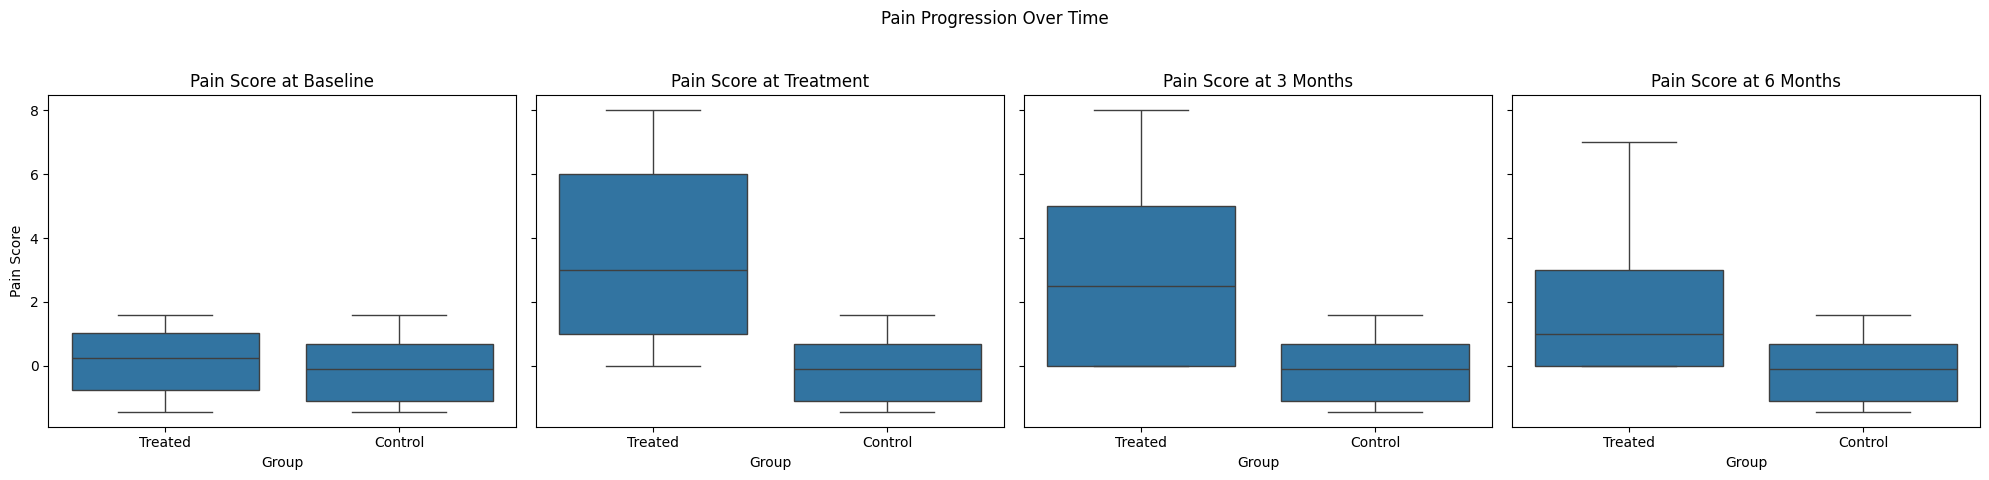

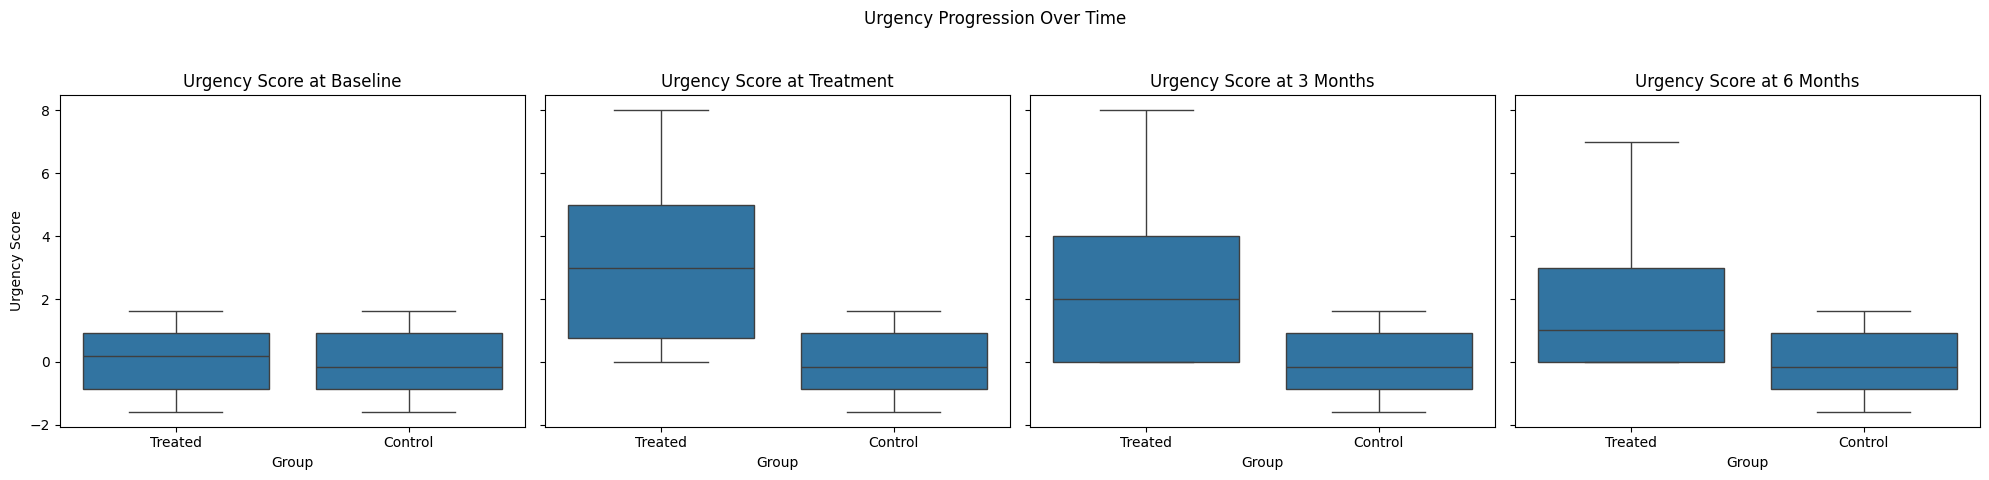

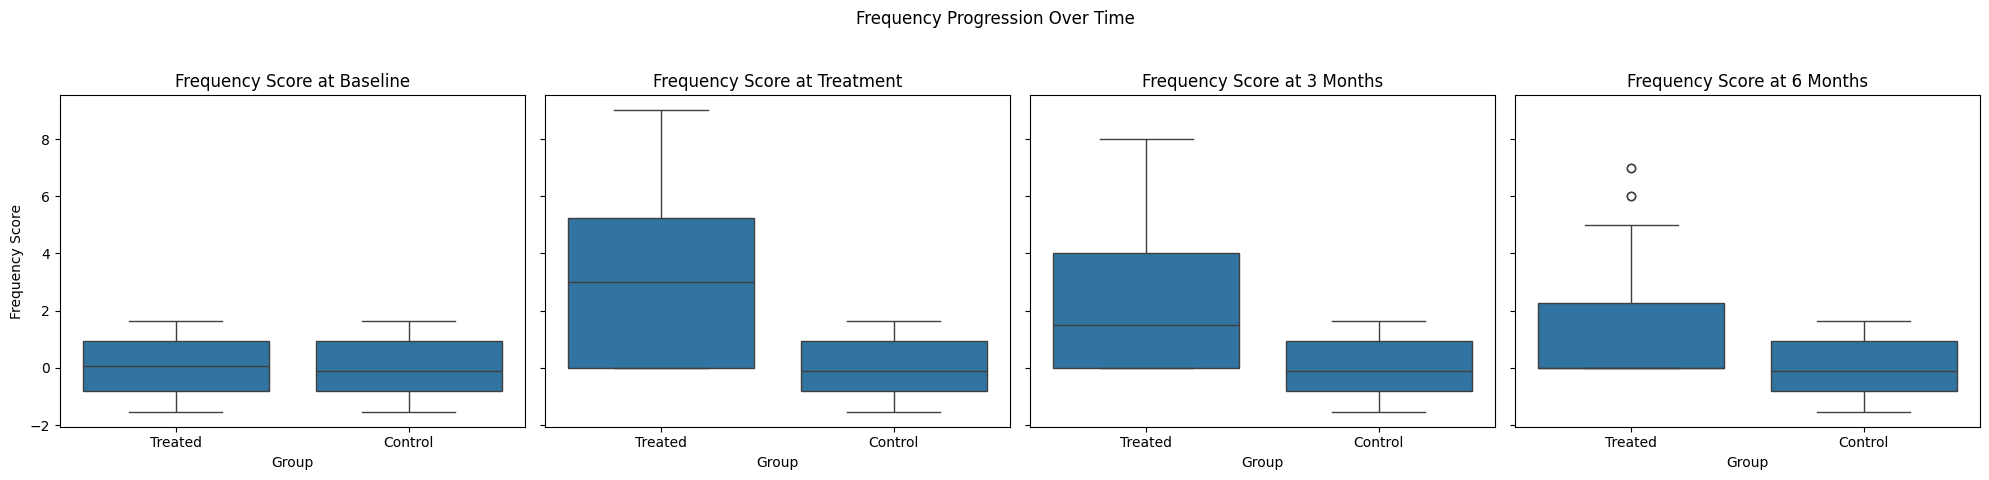

In [17]:

# For untreated patients, impute treatment-specific values with baseline values.
for symptom in ['pain', 'urgency', 'frequency']:
    for tp in ['treatment', '3months', '6months']:
        col = f"{symptom}_{tp}"
        data.loc[data["treated"] == 0, col] = data.loc[data["treated"] == 0, f"{symptom}_baseline"]

# Helper function to convert wide-format symptom data to long format.
def create_long_format_symptom(df, symptom):
    cols = [f"{symptom}_baseline", f"{symptom}_treatment", f"{symptom}_3months", f"{symptom}_6months"]
    mapping = {
        f"{symptom}_baseline": "Baseline",
        f"{symptom}_treatment": "Treatment",
        f"{symptom}_3months": "3 Months",
        f"{symptom}_6months": "6 Months"
    }
    long_df = df[['patient_id', 'treated'] + cols].melt(
        id_vars=['patient_id', 'treated'],
        value_vars=cols,
        var_name='time_point',
        value_name=symptom
    )
    # Map the variable names to readable time labels.
    long_df['time_point'] = long_df['time_point'].map(mapping)
    # Create a column for group labels.
    long_df['Group'] = long_df['treated'].map({1: 'Treated', 0: 'Control'})
    return long_df

# Create DataFrames for each symptom.
pain_long = create_long_format_symptom(data, 'pain')
urgency_long = create_long_format_symptom(data, 'urgency')
frequency_long = create_long_format_symptom(data, 'frequency')

# Define the order of time points.
time_points = ["Baseline", "Treatment", "3 Months", "6 Months"]

# Visualization (Pain)
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, tp in enumerate(time_points):
    subset = pain_long[pain_long['time_point'] == tp]
    sns.boxplot(x='Group', y='pain', data=subset, ax=axes[i])
    axes[i].set_title(f"Pain Score at {tp}")
    axes[i].set_xlabel("Group")
    if i == 0:
        axes[i].set_ylabel("Pain Score")
    else:
        axes[i].set_ylabel("")
plt.suptitle("Pain Progression Over Time")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Visualization (Urgency)
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, tp in enumerate(time_points):
    subset = urgency_long[urgency_long['time_point'] == tp]
    sns.boxplot(x='Group', y='urgency', data=subset, ax=axes[i])
    axes[i].set_title(f"Urgency Score at {tp}")
    axes[i].set_xlabel("Group")
    if i == 0:
        axes[i].set_ylabel("Urgency Score")
    else:
        axes[i].set_ylabel("")
plt.suptitle("Urgency Progression Over Time")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Visualization (Frequency)
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, tp in enumerate(time_points):
    subset = frequency_long[frequency_long['time_point'] == tp]
    sns.boxplot(x='Group', y='frequency', data=subset, ax=axes[i])
    axes[i].set_title(f"Frequency Score at {tp}")
    axes[i].set_xlabel("Group")
    if i == 0:
        axes[i].set_ylabel("Frequency Score")
    else:
        axes[i].set_ylabel("")
plt.suptitle("Frequency Progression Over Time")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final Research Report and Conclusions

## Methodology

This study employed a multi-step approach to evaluate the treatment effect on patient symptoms. The process included:

- **Data Collection & Preprocessing:** A dataset was simulated containing treatment times, symptom histories (at baseline, at treatment, 3 months, and 6 months), demographic variables, and an unobserved factor representing hidden bias.
- **Risk Set Matching:** For each treated patient, untreated patients were selected into a risk set based on comparable baseline symptom measures and entry times. Mahalanobis distances were computed to quantify similarity.
- **Optimal Matching via Integer Programming:** An optimization procedure was used to match each treated patient with one control patient, minimizing the total Mahalanobis distance and ensuring covariate balance.
- **Sensitivity Analysis for Hidden Bias:** A Cox proportional hazards model was fit and re-fit over a range of assumed strengths (Γ) for an unobserved confounder to assess the robustness of the treatment effect.
- **Statistical Analysis & Interpretation:** Paired tests (Wilcoxon Signed-Rank and permutation tests) were conducted on the primary outcome (e.g., pain score at 6 months), and symptom progression over time was visualized using boxplots.

## Key Findings

- The matched dataset shows well-balanced covariate distributions between treated and control patients.
- Paired hypothesis testing did not reveal a statistically significant treatment effect on the primary outcome (pain at 6 months).
- Sensitivity analysis indicates that the treatment effect estimates remain stable across a range of assumptions about unobserved bias, suggesting robustness of the findings.
- Visualizations of symptom progression over time indicate that, while treated patients may show modest improvements, the differences compared to controls are not statistically significant.

## Potential Biases and Limitations

- Residual confounding may exist if important unmeasured variables were not captured by the simulated unobserved factor.
- Imputation of untreated patients’ follow-up outcomes with baseline values may not perfectly reflect their natural symptom progression.
- The simulation parameters and sample size may limit the generalizability of these findings.

## Conclusions

Overall, the analysis does not support a statistically significant treatment effect on the primary outcome under the current study design and assumptions. The sensitivity analysis further supports that the findings are robust to a range of plausible unobserved biases. Future research should validate these findings using real-world data and possibly incorporate additional covariates.

In [18]:
# Extract outcomes for the matched treated and control groups.
treated_pain = data[data["patient_id"].isin(matched_df["Treated Patient"])]["pain_6months"]
control_pain = data[data["patient_id"].isin(matched_df["Control Patient"])]["pain_6months"]

desc_treated = treated_pain.describe().to_frame().T
desc_control = control_pain.describe().to_frame().T

display(HTML("<h3>Descriptive Statistics for Treated Group (Pain at 6 Months)</h3>"))
display(desc_treated)
display(HTML("<h3>Descriptive Statistics for Control Group (Pain at 6 Months)</h3>"))
display(desc_control)

# Sensitivity Analysis Results
display(HTML("<h3>Sensitivity Analysis Results</h3>"))
display(sensitivity_df)

# Display a Reminder of Symptom Progression Visualizations
display(HTML("""
<h3>Symptom Progression Over Time</h3>
<p>
Boxplots for pain, urgency, and frequency scores at Baseline, Treatment, 3 Months, and 6 Months (separated by Treated and Control groups) have been generated in Step 5.
These visualizations demonstrate that treated patients exhibit modest improvement over time; however, the differences compared to controls are not statistically significant.
</p>
"""))

# Final Remarks
display(HTML("""
<h3>Final Remarks</h3>
<p>
The comprehensive analysis, incorporating advanced matching techniques, sensitivity analysis, and robust statistical testing, suggests that the treatment does not yield a significant improvement in the primary outcome under the current simulation parameters.
The findings appear robust to a range of assumptions about unobserved confounding, though residual biases may still be present.
</p>
"""))

,count,mean,std,min,25%,50%,75%,max
pain_6months,60.0,1.866667,2.189858,0.0,0.0,1.0,3.0,7.0


,count,mean,std,min,25%,50%,75%,max
pain_6months,60.0,0.24045,0.975609,-1.437633,-0.170624,0.251713,1.26532,1.603189


,Gamma (Hidden Bias Factor),Treatment Coefficient,p-value
0,0.0,-0.3033,0.1075
1,0.1,-0.3065,0.1056
2,0.2,-0.3065,0.1056
3,0.3,-0.3065,0.1056
4,0.4,-0.3065,0.1056
5,0.5,-0.3065,0.1056
6,0.6,-0.3065,0.1056
7,0.7,-0.3065,0.1056
8,0.8,-0.3065,0.1056
9,0.9,-0.3065,0.1056
